
# Convolution Neural Network

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import math
# import tensorflow as tf
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator

### Train data

In [2]:
epochs = 50
size = 50
ReqLabels = [1,3,14,33,34]#,36,37]

Train_Path = 'D:/Data/Traffic Signs/Train.csv'
Test_Path = 'D:/Data/Traffic Signs/Test.csv'
Meta_Path = 'D:/Data/Traffic Signs/Meta.csv'
Labels_Path = 'D:/Data/Traffic Signs/Labels.csv'

Labels = []
labelData = pd.read_csv(Labels_Path)
for i,j in zip(labelData['ClassId'] , labelData['SignName']) :
    if i in ReqLabels :
        Labels.append(j)
        
print(Labels)

['Speed limit (30kmph)', 'Speed limit (60kmph)', 'Stop', 'Turn right ahead', 'Turn left ahead']


In [3]:
loc = 'D:/CNN_1.0/train_test_5.0_Size50_fixed.obj'

In [4]:
Count_Labels = {}
for i in ReqLabels :
    Count_Labels[i] = 0

Count_Labels

{1: 0, 3: 0, 14: 0, 33: 0, 34: 0}

In [5]:
f = open(loc , 'rb')
X_train , Y_train , Labels = pickle.load(f)
#X_train , Y_train , X_test , Y_test , Labels = pickle.load(f)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

print(f"""X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}
X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}""")

X_train shape : (30391, 50, 50, 3), Y_train shape : (30391,)
X_test shape : (13026, 50, 50, 3), Y_test shape : (13026,)


In [6]:
fileName = 'Traffic_Signs_Detection_5.1.obj'

In [7]:
def callback(obj,fileName) :
    print('CallBack : ',fileName,'Updated')
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)

## Layers
---

In [8]:
class ReLU :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'ReLU'
    
    def feed(self,X) :
        self.input = X
        self.input_shape=X.shape
        self.output = np.maximum(0,X)
        self.output_shape = self.input_shape
        return self.output
    
    def feed_back(self,grad_output,lr) :
        grad = self.input > 0
        return grad_output*grad
    
class Softmax :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Softmax'
    
    def feed(self,X) :
        self.input = X
        e_x = np.exp(X-np.max(X))
        self.output = e_x/e_x.sum()
        return self.output
    
    def feed_back(self,grad_output,lr) :
        X = self.input
        e_x = np.exp(X-np.max(X))
        grad = e_x/e_x.sum()**2 - (e_x**2/(e_x.sum()**2))
        #print(grad)
        return grad_output*grad
    
class Sigmoid :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Sigmoid'
    
    def feed(self,X) :
        self.input = X
        self.output = 1/(1+np.exp(-X))
        return self.output
    
    def feed_back(self,grad_output,lr) :
        grad = self.output*((1-self.output)**2)
        return grad_output*grad

### Convolutional Layer

In [9]:
class Conv2D :
    
    def __init__ (self,N_F,K_S,input_shape,STRIDES=1) :
        self.__Name__ = 'Conv2D'
        self.__type__ = 'conv'
        self.N_F = N_F
        self.K_S = K_S
        self.STRIDES = STRIDES
        #self.A_F = A_F
        self.input_shape = input_shape
        while True :
            self.Filters = np.random.randint(-1,2,(self.N_F,self.input_shape[-1],self.K_S,self.K_S))
            co = 0
            for f in self.Filters :
                if np.all(f==0) :
                    self.Filters = np.random.randint(-1,2,(self.N_F,self.input_shape[-1],self.K_S,self.K_S))
                else :
                    co += 1
            if co == N_F :
                break
        self.res = np.zeros((self.input_shape[0]-self.K_S+1,self.input_shape[1]-self.K_S+1,self.N_F))
        self.bias = np.random.randint(-1,2,(self.N_F))
        self.output_shape = self.res.shape
    
#     def feed(self,X) :
#         self.input = X
#         self.output = np.zeros((self.input_shape[0]-self.K_S+1,self.input_shape[1]-self.K_S+1,self.N_F))
#         for i in range(0,self.output_shape[0],self.STRIDES) :
#             for j in range(0,self.output_shape[1],self.STRIDES) :
#                 cur_reg = X[i:i+self.K_S,j:j+self.K_S]
#                 cur_reg = cur_reg@self.Filters.T
#                 for c in range(self.N_F) :
#                     self.output[i,j,c] = np.sum(cur_reg[:,:,c])#/(self.output_shape[0]*self.output_shape[1]*self.output_shape[2])
#         return self.output

    def feed(self,X) :
        self.input = X
        self.output = np.zeros((self.input_shape[0]-self.K_S+1,self.input_shape[1]-self.K_S+1,self.N_F))
        for i in range(0,self.output_shape[0],self.STRIDES) :
            for j in range(0,self.output_shape[1],self.STRIDES) :
                #for c,Filter in enumerate(self.Filters) :
                cur_reg = X[i:i+self.K_S,j:j+self.K_S].T@self.Filters
                for c in range(self.N_F) :
                    self.output[i,j,c] = np.sum(cur_reg[c]) + self.bias[c]
                            
        return self.output
    
    def feed_back(self, output_error, learning_rate=0.1):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * weights_error / np.sqrt(self.input_shape + self.output_shape)
        self.bias -= learning_rate * output_error / np.sqrt(self.input_shape + self.output_shape)
        return input_error
    
    def plotImg(self,X=None) :
        if X is None :
            X = self.output
        Filter_SIZE = int(X.shape[-1]**(1/2))
        _, axs = plt.subplots(Filter_SIZE,Filter_SIZE, figsize=(8,8))
        axs = axs.flatten()
        for i , ax in enumerate(axs) :
            img = X[:,:,i]
            ax.axis('off')
            ax.imshow(img)
        plt.show()
        
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### Pool Layer

In [10]:
class MaxPool2D :
    
    def __init__ (self,K_S,input_shape,STRIDES=2) :
        self.__Name__ = 'MaxPool2D'
        self.__type__ = 'pool'
        self.K_S = K_S
        self.STRIDES = STRIDES
        self.A_F = None
        self.input_shape = input_shape
        self.output_shape = (int((self.input_shape[0]-self.K_S+1)/self.STRIDES),int((self.input_shape[0]-self.K_S+1)/self.STRIDES),self.input_shape[-1])
        
    def feed(self,X) :
        self.input = X
        W,H,D = self.output_shape
        self.output = np.zeros((W,H,D))
        w , h = 0 , 0
        for i in range(0,self.input_shape[0]-self.K_S,self.STRIDES) :
            for j in range(0,self.input_shape[1]-self.K_S,self.STRIDES) :
                self.output[w,h] = np.max(np.max(X[i:i+self.K_S,j:j+self.K_S].T,axis=1),axis=1)
                h += 1
            h = 0
            w += 1
            
        return self.output
    
    def plotImg(self,X=None) :
        if X is None :
            X = self.output
        Filter_SIZE = int(X.shape[-1]**(1/2))
        _, axs = plt.subplots(Filter_SIZE,Filter_SIZE, figsize=(8,8))
        axs = axs.flatten()
        for i , ax in enumerate(axs) :
            img = X[:,:,i]
            ax.axis('off')
            ax.imshow(img)
        plt.show()
        
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### Flatten Layer

In [11]:
class Flatten :
    
    def __init__ (self,input_shape=None) :
        self.__Name__ = 'Flatten'
        self.__type__ = 'flat'
        self.input_shape = input_shape
        self.A_F = None
        re = 1
        for i in input_shape :
            re *= i
        self.output_shape = re
        
    def feed(self,X) :
        self.input = X
        self.output = X.ravel()
        return self.output
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

### Dense Layer

In [12]:
class Dense :
    
    def __init__ (self,input_shape,N_F) :
        self.__Name__ = 'Dense'
        self.__type__ = 'dense'
        self.input_shape = input_shape
        self.N_F = N_F
        #self.A_F = A_F
        self.output_shape = N_F
        self.weights = 0.1*np.random.randn(self.input_shape, self.output_shape) / np.sqrt(self.input_shape + self.output_shape)
        self.bias = np.random.randn(1, self.output_shape) / np.sqrt(self.input_shape + self.output_shape)
        
    def feed(self,X) :
        if X.shape[0] != 1 :
            output = []
            output.append(X)
            self.input = np.array(output)
        else :
            self.input = X
        self.output = np.dot(X,self.weights) + self.bias
        return self.output
    
    def feed_back(self, output_error, learning_rate=[1e-03]):
        lr = learning_rate[np.random.randint(len(learning_rate))]
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= lr * weights_error# / np.sqrt(self.input_shape + self.output_shape)
        self.bias -= lr * output_error #/ np.sqrt(self.input_shape + self.output_shape)
        return input_error
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [13]:
class Sequential :
    
    def __init__ (self) :
        self.Layers = []
        self.input_shape = None
        self.activations = []
        
    def add(self,Layer) :
        self.Layers.append(Layer)
        if Layer.__type__ != 'activation' :
            if self.input_shape is None :
                self.input_shape = Layer.input_shape
            self.output_shape = Layer.output_shape
            #self.activations.append(Layer.A_F)
        
    def compile(self,loss='cross_entropy',metrics=['acc']) :
        self.loss = loss
        self.metrics = metrics
        
    def one_hot_encode(self,labels) :
        Labels = np.zeros((len(labels),len(set(labels))))
        for i,label in enumerate(labels) :
            Labels[i][label] = 1
        return Labels
        
    def fit(self,train_data,valid_data=None,validation_split=.1,epochs=10,lr=0.01,Labels=None) :
        self.acc = []
        self.val_acc = []
        self.error = []
        self.val_error = []
        self.epochs = epochs
        
        if Labels is not None :
            model.Labels = Labels
        
        input_data , output_data , val_input_data , val_output_data , Total = None , None , None , None , None
        
        if train_data is None :
            raise ValueError('Training Data Required')
        else :
            input_data = train_data[0]
            Total = train_data[1]
            output_data = Total
        N = len(input_data)
        
        if valid_data is None :
            if validation_split != 0 :
                n = int(len(input_data)*(1-validation_split))
                K = np.random.randint(0,N,(N))
                for i in range(N-1) :
                    train_data[0][K[i]] = train_data[0][K[i+1]]
                    train_data[1][K[i]] = train_data[1][K[i+1]]
                input_data , output_data = train_data[0][:n] , output_data[:n]
                val_input_data , val_output_data = train_data[0][n:] , output_data[n:]
        else :
            val_input_data , val_output_data = valid_data[0] , valid_data[1]
            
        #N = len(self.input)
        
        print('\nModel Fitting\n')
        
        for ep in range(epochs) :
            error = 0
            pre_error = 0
            ratio = 0
            val_ratio = 0
            for c,(X,Y) in enumerate(zip(input_data , output_data)) :
                output = X
                ### Forward Feeding
                for Layer in self.Layers :
                    output = Layer.feed(output)
                loss = 0
                out_err = 0
                
                if self.loss == 'cross_entropy' :
                    loss = self.crossentropy(output,Y)
                    out_err = self.grad_crossentropy(output,Y)
                elif self.loss == 'mean_squared_error' :
                    loss = self.mse(Y,output)
                    out_err = (Y-output)*self.transfer_derivative(output)
                    
                #print(loss,out_err,output)
                #print('->',output,np.sum(output))
                
                # Backward Feeding
                for Layer in reversed(self.Layers) :
                    #print('=>',out_err)
                    #if Layer.__Name__ != 'Softmax' :
                        if Layer.__Name__ != 'Flatten' :
                            out_err = Layer.feed_back(out_err,lr)
                        else :
                            break
                        
                error = np.mean(loss)
                
                print('\repoch %d/%d, error=%f' % (ep + 1, epochs, error),end="")
            error = np.mean(loss)
            ratio = sum([y == np.argmax(model.predict(x)) for x, y in zip(input_data, output_data)]) / len(output_data)
            self.acc.append(ratio)

            if 'acc' in self.metrics :
                val_ratio = sum([y == np.argmax(model.predict(x)) for x, y in zip(val_input_data,
                                                                                  val_output_data)]) / len(val_input_data)
                self.val_acc.append(val_ratio)
                print('\repoch %d/%d, error=%f , acc=%f , val_acc=%f' % (ep + 1, epochs, error, ratio , val_ratio))
            else :
                print('\repoch %d/%d, error=%f , acc=%f' % (ep + 1, epochs , error , ratio))
                
            callback(self,fileName)
            
            if ep == 5 :
                lr = [1e-03,1e-05]
            
    def mse(self,y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def mse_prime(self,y_true, y_pred):
        return 2 * (y_pred - y_true) / y_pred.size
    
    def transfer_derivative(self,output):
        return output * (1.0 - output)
    
    def crossentropy(self,logits,reference_answers):
        return - logits[0][reference_answers] + np.log(np.sum(np.exp(logits),axis=-1))
    
    def grad_crossentropy(self,logits,reference_answers):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)),reference_answers] = 1
        softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
        return (- ones_for_answers + softmax) / logits.shape[0]
    
    def showImg(self,X) :
        plt.imshow(X)
        plt.show()
    
    def predict(self,X):
        soft = Softmax()
        if X.shape == model.input_shape :
            output = X
            for Layer in self.Layers :
                output = Layer.feed(output)
            return soft.feed(output)
        else :
            outputs = []
            for x in X :
                out = x
                for Layer in self.Layers :
                    out = Layer.feed(out)
                outputs.append(soft.feed(out))
            return np.array(outputs)
    
    def pred_class(self,X) :
        output = X
        for Layer in self.Layers :
            output = Layer.feed(output)
        return np.argmax(output)
    
    def Summary(self) :
        print('_'*60)
        print('Model Summary')
        print('_'*60)
        print('Layers',' '*(20-len('Layers')),'Input Shape',' '*(20-len('Input Shape')),'Output Shape',' '*(20-len('Output Shape')))
        print('_'*60)
        for Layer in self.Layers :
            if Layer.__type__ != 'activation' :
                Layer.Summary()
                print('_'*60)

In [14]:
model = Sequential()
# model.add(Conv2D(3,3,input_shape=X_train[0].shape))
# model.add(ReLU())
# model.add(MaxPool2D(5,STRIDES=3,input_shape=model.output_shape))
# model.add(Conv2D(8,3,input_shape=model.output_shape))
# model.add(MaxPool2D(5,STRIDES=3,input_shape=model.output_shape))
# model.add(Flatten(input_shape=model.output_shape))
model.add(Flatten(input_shape=X_train[0].shape))
# model.add(Dense(input_shape=model.output_shape,N_F=100))
model.add(ReLU())
# model.add(Dense(input_shape=model.output_shape,N_F=32))
model.add(Dense(input_shape=model.output_shape,N_F=len(set(Y_train))))
# model.add(Softmax())
# model.add(Sigmoid())
model.compile(loss='cross_entropy',metrics=['acc'])

model.Summary()
model.fit(train_data=(X_train,Y_train),
          epochs=20,lr=[1e-02,1e-03,1e-04,1e-05],
          Labels=Labels,valid_data=(X_test,Y_test) )

____________________________________________________________
Model Summary
____________________________________________________________
Layers                Input Shape           Output Shape         
____________________________________________________________
Flatten               (50, 50, 3)           7500
____________________________________________________________
Dense                 7500                  6
____________________________________________________________

Model Fitting

epoch 1/20, error=0.000000 , acc=0.826857 , val_acc=0.829495
CallBack :  Traffic_Signs_Detection_5.1.obj Updated
epoch 2/20, error=0.008509 , acc=0.996413 , val_acc=0.996162
CallBack :  Traffic_Signs_Detection_5.1.obj Updated
epoch 3/20, error=0.004824 , acc=0.996051 , val_acc=0.995701
CallBack :  Traffic_Signs_Detection_5.1.obj Updated
epoch 4/20, error=0.000129 , acc=0.995986 , val_acc=0.996238
CallBack :  Traffic_Signs_Detection_5.1.obj Updated
epoch 5/20, error=0.009060 , acc=0.996381 , val_acc=

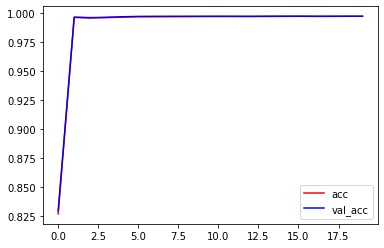

In [15]:
plt.plot(range(model.epochs),model.acc,c='r',label='acc')
plt.plot(range(model.epochs),model.val_acc,c='b',label='val_acc')
plt.legend()
plt.show()

---

### Predicting

[[9.99999999e-01 5.82788582e-10 1.17583387e-20 1.91177366e-22
  2.82939936e-21 1.45672505e-13]]


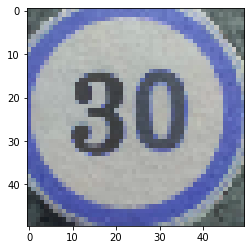

Speed limit (30kmph)


In [16]:
cc = 765
print(model.predict(X_train[cc]))
cla = model.pred_class(X_train[cc])
plt.imshow(X_train[cc])
plt.show()
print(Labels[cla])

In [17]:
cv2.imshow('Frame',X_train[1000])
if cv2.waitKey(0) & 0xFF == ord('q'):
    cv2.destroyAllWindows()

In [18]:
def ROI(img,pos=[200,0,300,150],kernels=[75],stride=5) : # [X1 , Y1 , X2 , Y2] ROI for Object Detection
    ROIs = []
    Locs = []
    for ks in kernels :
        for x in range(pos[0],pos[2]-ks+stride,stride) :
            for y in range(pos[1],pos[3]-ks+stride,stride) :
                Locs.append([x,y,ks])
                im = cv2.resize(img[y:y+ks,x:x+ks],(model.input_shape[0],model.input_shape[1]))
                ROIs.append(im)
    ROIs = np.array(ROIs)/255.
    return Locs,model.predict(ROIs)

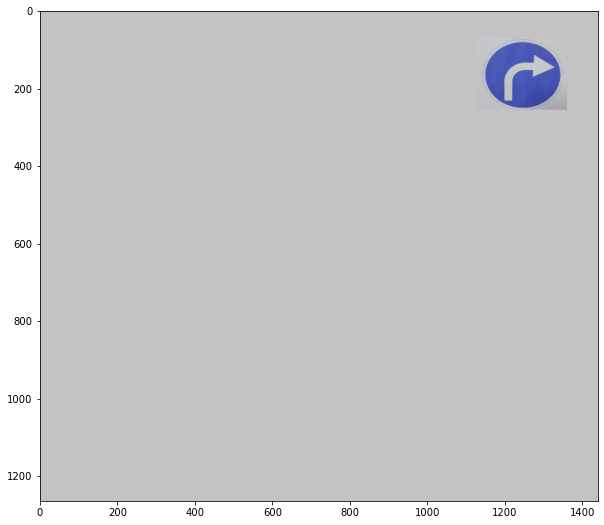

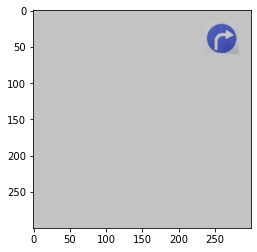

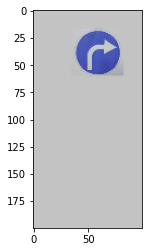

In [19]:
img = cv2.imread('Traffic_right.png')
#img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()
img = cv2.resize(img,(300,300))
plt.imshow(img)
plt.show()

plt.imshow(img[0:200,200:300])
plt.show()

In [20]:
import time
start = time.time()
Locs,preds = ROI(img)
print(time.time()-start)

0.08375763893127441


In [21]:
for i in range(len(preds)) :
    preds[i] = preds[i].ravel()

In [22]:
max_ = 1
ind = None
for i in preds :
    if max_ <= i[0][np.argmax(i)] :
        max_ = i[0][np.argmax(i)]
        ind = np.where(preds == i)

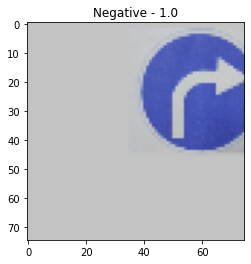

In [23]:
for ind_,(i,j) in enumerate(zip(preds,Locs)) :
    if ind_ == ind[0][0] :
        plt.title(Labels[np.argmax(i)] + ' - ' + str(i[0][np.argmax(i)]))
        plt.imshow(img[j[1]:j[1]+j[2],j[0]:j[0]+j[2]])
        plt.show()

In [24]:
print(model.predict(X_train[0]))
print(model.pred_class(X_train[0]))

[[4.54040325e-28 4.25158396e-16 9.14475218e-15 1.21223357e-15
  1.00000000e+00 1.21600625e-17]]
4


In [25]:
c = 0
for i in range(len(X_test)) :
    print(Y_test[i],model.pred_class(X_test[i]))
    if model.pred_class(X_test[i]) == Y_test[i] :
        c += 1
        #plt.imshow(X_test[i])
        #plt.show()
#     else :
#         plt.imshow(X_test[i])
#         plt.show()
print(c*100/len(X_test))

0 0
1 1
4 4
0 0
3 3
0 0
2 2
3 3
5 5
2 2
0 0
2 2
1 1
5 5
0 0
2 2
5 5
5 5
5 5
1 1
5 5
4 4
3 3
5 5
0 0
3 3
0 0
4 4
1 1
4 4
0 0
5 5
0 0
3 3
4 4
5 5
5 5
1 1
5 5
4 4
2 2
5 5
0 0
3 3
0 0
0 0
1 1
2 2
4 4
0 0
4 4
1 1
4 4
4 4
4 4
1 1
2 2
2 2
1 1
3 3
5 5
5 5
0 0
4 4
5 5
1 1
3 3
1 1
1 1
5 5
3 3
2 2
4 4
3 3
3 3
1 1
5 5
0 0
1 1
5 5
3 3
0 0
3 3
2 2
3 3
5 5
5 5
0 0
4 4
1 1
4 4
0 0
3 3
3 3
1 1
1 1
5 5
4 4
3 3
2 2
0 0
1 1
0 0
1 1
5 5
4 4
4 4
3 3
0 0
5 5
1 1
0 0
5 5
3 3
0 0
1 1
0 0
4 4
0 0
4 4
0 0
5 5
2 2
0 0
5 5
1 1
1 1
4 4
1 1
1 1
4 4
5 5
5 5
2 2
2 2
1 1
0 0
0 0
5 5
4 4
4 4
1 1
1 1
3 3
2 2
0 0
2 2
1 1
1 1
0 0
5 5
2 2
5 5
5 5
4 4
5 5
4 4
1 1
4 4
2 2
4 4
4 4
2 2
4 4
5 5
1 1
3 3
3 3
2 2
3 3
5 5
1 1
3 3
1 1
1 1
5 5
3 3
5 5
0 0
3 3
5 5
1 1
4 4
3 3
2 2
5 5
4 4
4 4
2 2
4 4
2 2
5 5
5 5
2 2
0 0
3 3
5 5
5 5
1 1
3 3
0 0
2 2
5 5
2 2
3 3
0 0
5 5
2 2
3 3
1 1
2 2
2 2
2 2
4 4
2 2
4 4
3 3
5 5
0 0
4 4
3 3
5 5
3 3
5 5
2 2
1 1
1 1
4 4
5 5
4 4
0 0
5 5
2 2
0 0
2 2
5 5
1 1
4 4
3 3
2 2
1 1
5 5
4 4
0 0
5 5
5 5
5 5
3 3
2 2
4 4


5 5
1 1
4 4
2 2
4 4
1 1
0 0
4 4
1 1
1 1
1 1
4 4
4 4
5 5
5 5
0 0
2 2
1 1
4 4
4 4
1 1
2 2
0 0
3 3
0 0
5 5
5 5
4 4
4 4
1 1
4 4
1 1
0 0
3 3
2 2
3 3
3 3
0 0
4 4
2 2
0 0
1 1
3 3
1 1
2 2
3 3
5 5
3 3
2 2
5 5
0 0
5 5
4 4
0 0
0 0
5 5
4 4
1 1
4 4
1 1
0 0
5 5
2 2
2 2
3 3
2 2
0 0
3 3
5 5
4 4
0 0
5 5
1 1
4 4
1 1
4 4
4 4
2 2
1 1
2 2
5 5
3 3
4 4
3 3
4 4
1 1
3 3
5 5
2 2
0 0
2 2
1 1
2 2
5 5
5 5
2 2
5 5
1 1
5 5
3 3
3 3
2 2
3 3
4 4
2 2
1 1
0 0
1 1
4 4
2 2
5 5
3 3
3 3
5 5
0 0
5 5
4 4
3 3
0 0
2 2
4 4
5 5
5 5
0 0
3 3
5 5
2 2
4 4
3 3
2 2
4 4
2 2
4 4
4 4
3 3
1 1
5 5
5 5
1 1
0 0
2 2
0 0
4 4
4 4
0 0
1 1
2 2
4 4
4 4
4 4
1 1
5 5
3 3
2 2
5 5
0 0
4 4
2 2
1 1
1 1
1 1
0 0
1 1
1 1
1 1
5 5
3 3
5 5
1 1
0 0
2 2
3 3
1 1
0 0
2 2
5 5
4 4
0 0
1 1
0 0
1 1
0 0
4 4
1 1
3 3
0 0
1 1
0 0
5 5
1 1
4 4
0 0
3 3
1 1
1 1
0 0
5 5
2 2
3 3
1 1
1 1
5 5
2 2
0 0
4 4
5 5
2 2
1 1
2 2
5 5
2 2
2 2
1 1
0 0
2 5
3 3
0 0
1 1
0 0
4 4
4 4
2 2
1 1
0 0
0 0
3 3
5 5
4 4
0 0
3 3
2 2
0 0
4 4
0 0
4 4
5 5
1 1
3 3
1 1
1 1
3 3
5 5
3 3
4 4
4 4
4 4
2 2
2 2
0 0
1 1


1 1
0 0
0 0
5 5
3 3
3 3
2 2
5 5
4 4
5 5
5 5
5 5
2 2
3 3
4 4
1 1
4 4
5 5
0 0
1 1
5 5
0 0
1 1
1 1
3 3
0 0
3 3
0 0
2 2
2 2
0 0
4 4
4 4
4 4
1 1
2 2
3 3
0 0
5 5
2 2
5 5
0 0
1 1
1 1
3 3
5 5
1 1
1 1
1 1
3 3
3 3
3 3
2 2
0 0
4 4
2 2
0 0
1 1
2 2
1 1
3 3
5 5
5 5
2 2
4 4
4 4
0 0
0 5
3 3
3 3
1 1
0 0
4 4
4 4
4 4
5 5
5 5
4 4
5 5
3 3
0 0
2 2
0 0
3 3
2 2
2 2
1 1
4 4
2 2
5 5
4 4
5 5
5 5
3 3
4 4
5 5
4 5
2 2
0 0
5 5
3 3
0 0
3 3
3 3
5 5
4 4
3 3
2 2
0 0
1 1
2 2
2 2
1 1
2 2
2 2
5 5
5 5
1 1
0 0
1 1
4 4
0 0
2 2
3 3
1 1
2 2
0 0
1 1
4 4
1 1
3 3
0 0
4 4
4 4
4 4
1 1
5 5
0 0
1 1
0 0
2 2
5 5
1 1
0 0
4 4
1 1
2 2
2 2
2 2
1 1
4 4
2 2
5 5
0 0
5 5
0 0
4 4
0 0
1 1
5 5
5 5
1 1
3 3
2 2
1 1
5 5
1 1
1 1
1 1
2 2
5 5
4 4
2 2
2 2
3 3
4 4
4 4
0 0
5 5
1 1
5 5
5 5
0 0
5 5
5 5
5 5
3 3
3 3
3 3
1 1
2 2
4 4
2 2
1 1
2 2
1 1
4 4
3 3
2 2
1 1
0 0
5 5
5 5
5 5
3 3
2 2
5 5
0 0
4 4
5 5
1 1
4 4
3 3
5 5
1 1
3 3
2 2
0 0
5 5
5 5
4 4
0 0
2 2
1 1
2 2
3 3
0 0
2 2
0 0
5 5
3 3
2 2
1 1
5 5
2 2
3 3
5 5
1 1
1 1
1 1
2 2
1 1
0 0
3 3
5 5
2 2
5 5
0 0
0 0
5 5


4 4
4 4
5 5
0 0
2 2
2 2
5 5
3 3
1 1
1 1
5 5
5 5
4 4
5 5
3 3
1 1
1 1
4 4
3 3
0 0
4 4
0 0
5 5
1 1
3 3
0 0
5 5
4 4
4 4
0 0
3 3
5 5
0 0
2 2
5 5
5 5
2 5
1 1
2 2
3 3
5 5
0 0
3 3
5 5
4 4
2 2
0 0
0 0
5 5
3 3
5 5
5 5
5 5
5 5
1 1
2 2
3 3
5 5
0 0
2 2
3 3
4 4
1 1
3 3
0 0
5 5
4 4
5 5
2 2
1 1
4 4
4 4
5 5
5 5
0 0
2 2
5 5
1 1
4 4
4 4
4 4
5 5
4 4
0 0
1 1
1 1
2 2
3 3
1 1
5 5
5 5
2 2
0 5
4 4
1 1
1 1
5 5
2 2
5 5
5 5
3 3
5 5
5 5
5 5
4 4
5 5
1 1
3 3
1 1
0 0
3 3
4 4
5 5
1 1
4 4
1 1
0 0
3 3
0 0
2 2
4 4
1 1
4 4
2 2
0 0
1 1
4 4
0 0
5 5
5 5
4 4
5 5
0 0
2 2
4 4
5 5
3 3
5 5
5 5
0 0
1 1
5 5
1 1
5 5
5 5
5 5
5 5
2 2
2 2
1 1
4 4
1 1
5 5
4 4
0 0
2 2
3 3
5 5
3 3
2 2
0 0
5 5
4 4
5 5
5 5
5 5
0 0
2 2
4 4
3 3
2 2
1 1
0 0
1 1
3 3
1 1
5 5
5 5
3 3
0 0
3 3
0 0
3 3
5 5
0 0
5 5
2 2
5 5
0 0
3 3
0 0
4 4
4 4
5 5
2 2
5 5
2 2
4 4
2 2
4 4
2 2
3 3
4 4
5 5
0 0
5 5
3 3
4 4
5 5
2 2
4 4
1 1
2 2
0 0
1 1
5 5
3 3
4 4
5 5
5 5
3 3
1 1
1 1
2 2
5 5
0 0
3 3
5 5
2 2
1 1
5 5
3 3
5 5
5 5
5 5
5 5
2 2
2 2
2 2
0 0
5 5
3 3
4 4
1 1
0 0
2 2
2 2
2 2
1 1
3 3


5 5
4 4
3 3
5 5
1 1
0 0
5 5
0 0
0 0
2 2
2 2
0 0
0 0
5 5
1 1
0 0
5 5
4 4
0 0
0 0
0 0
1 1
0 0
3 3
1 1
2 2
2 2
1 1
4 4
2 2
2 2
0 0
3 3
2 2
4 4
3 3
5 5
1 1
4 4
5 5
4 4
5 5
4 4
2 2
1 1
1 1
2 2
2 2
5 5
2 2
5 5
4 4
2 2
1 1
1 1
4 4
3 3
5 5
1 1
1 1
0 0
3 3
4 4
1 1
3 3
3 3
2 2
4 4
4 4
4 4
1 1
1 1
2 2
4 4
5 5
2 2
0 0
1 1
2 2
0 0
4 4
3 3
5 5
1 1
5 5
3 3
3 3
5 5
2 2
1 1
4 4
3 3
3 3
2 2
4 4
5 5
0 0
3 3
2 2
1 1
1 1
0 0
0 0
2 2
5 5
4 4
2 2
2 2
3 3
0 5
0 0
4 4
5 5
3 3
5 5
2 2
5 5
0 0
1 1
1 1
0 0
5 5
5 5
3 3
1 1
0 0
4 4
2 2
2 2
4 4
3 3
4 4
0 0
2 2
3 3
1 1
3 3
1 1
5 5
3 3
2 2
0 0
0 0
1 1
3 3
3 3
4 4
2 2
0 0
4 4
5 5
4 4
0 0
3 3
5 5
4 4
1 1
1 1
4 4
0 0
1 1
2 2
3 3
4 4
2 2
0 0
5 5
3 3
4 4
5 5
5 5
5 5
1 1
1 1
4 4
5 5
0 0
5 5
0 0
4 4
1 1
4 4
2 2
1 1
2 2
0 0
0 0
5 5
2 2
3 3
5 5
1 1
2 2
0 0
3 3
2 2
1 1
3 3
4 4
3 3
1 1
0 0
5 5
3 3
4 4
4 4
2 2
1 1
1 1
2 2
1 1
5 5
4 4
5 5
4 4
0 0
1 1
5 5
4 4
5 5
3 3
2 2
2 2
5 5
2 2
3 3
1 1
0 0
4 4
4 4
4 4
1 1
1 1
1 1
4 4
1 1
1 1
2 2
3 3
2 2
0 0
3 3
2 2
3 3
2 2
1 1
2 2
3 3
5 5
2 2


0 0
4 4
5 5
5 5
0 0
2 2
5 5
3 3
1 1
5 5
3 3
3 3
0 0
3 3
2 2
2 2
4 4
5 5
1 1
3 3
0 0
2 2
1 1
5 5
2 2
0 0
5 5
4 4
2 2
3 3
0 0
2 2
5 5
2 2
0 0
5 5
5 5
4 4
0 0
1 1
2 2
2 2
4 4
2 2
1 1
2 2
1 1
0 0
5 5
0 0
5 5
4 4
1 1
1 1
4 4
1 1
2 2
2 2
3 3
2 2
4 4
4 4
1 1
1 1
5 5
5 5
5 5
2 2
0 0
2 2
2 2
5 5
1 1
4 4
0 0
0 0
3 3
3 3
5 5
3 3
3 3
1 1
3 5
3 3
4 4
1 1
3 3
1 1
3 3
5 5
5 5
5 5
1 1
2 2
0 0
3 3
1 1
5 5
2 2
1 1
5 5
1 1
0 0
1 1
0 0
1 1
0 0
4 4
4 4
5 5
2 2
1 1
4 4
2 2
3 3
0 0
5 5
3 5
4 4
3 3
5 5
1 1
4 4
5 5
2 2
3 3
0 0
0 0
1 1
1 1
5 5
1 1
4 4
1 1
5 5
0 0
1 1
0 0
0 0
2 2
3 3
5 5
5 5
0 0
0 0
2 2
5 5
4 4
5 5
2 2
0 0
5 5
4 4
5 5
4 4
4 4
0 0
5 5
5 5
1 1
0 0
5 5
2 2
5 5
1 1
2 2
0 0
0 0
1 1
4 4
2 2
3 3
5 5
4 4
3 3
0 0
3 3
5 5
1 1
1 1
4 4
3 3
3 3
0 0
4 4
1 1
0 0
2 5
2 2
2 2
0 0
2 2
5 5
5 5
0 0
4 4
4 4
0 0
0 0
0 0
5 5
2 2
2 2
2 2
0 0
1 1
2 2
5 5
4 4
1 1
3 3
0 0
1 1
5 5
3 3
5 5
2 2
5 5
1 1
5 5
1 1
2 2
0 0
4 4
2 2
2 2
4 4
5 5
5 5
5 5
2 2
0 0
5 5
5 5
4 4
5 5
2 2
3 3
4 4
2 2
3 3
1 1
1 1
3 3
3 3
0 0
5 5
1 1
4 4
5 5


0 0
4 4
2 2
3 3
3 3
4 4
1 1
2 2
3 3
3 3
4 4
1 1
0 0
0 0
3 3
3 3
1 1
1 1
1 1
0 0
3 3
1 1
2 2
2 2
2 2
3 3
2 2
5 5
1 1
1 1
3 3
5 5
3 3
2 2
0 0
2 2
5 5
5 5
0 0
1 1
4 4
5 5
3 3
2 2
4 4
3 3
1 1
5 5
4 4
1 1
0 0
5 5
2 2
0 0
2 2
0 0
4 4
0 0
2 2
0 0
3 3
2 2
1 1
4 4
4 4
5 5
3 3
3 3
0 0
1 1
3 3
1 1
0 0
4 4
3 3
4 4
2 2
5 5
5 5
1 1
0 0
4 4
3 3
2 2
4 4
5 5
5 5
1 1
5 5
1 1
3 3
2 2
5 5
1 1
5 5
1 1
4 4
5 5
3 3
1 1
1 1
3 3
1 1
1 1
4 4
2 2
4 4
4 4
2 2
2 2
5 5
3 3
0 0
5 5
5 5
0 0
1 1
1 1
1 1
4 4
5 5
1 1
5 5
4 4
0 0
1 1
0 0
1 1
3 3
5 5
3 3
5 5
5 5
5 5
4 4
0 0
4 4
2 2
1 1
4 4
2 2
4 4
0 0
3 3
2 2
2 2
1 1
3 3
5 5
3 3
5 5
4 4
2 2
3 3
1 1
5 5
0 0
0 0
3 3
1 1
3 3
1 1
3 3
3 3
1 1
4 4
2 2
0 0
0 0
2 2
1 1
0 0
5 5
4 4
3 3
3 3
2 2
3 3
4 4
1 1
3 3
0 0
5 5
5 5
1 1
3 3
1 1
5 5
0 0
2 2
0 0
0 0
4 4
1 1
4 4
0 0
3 3
3 3
5 5
5 5
0 0
4 4
4 4
1 1
5 5
5 5
3 3
2 2
0 0
1 1
2 2
3 3
3 3
2 2
2 2
0 0
3 3
1 1
3 3
1 1
3 3
4 4
4 4
5 5
4 4
0 0
5 5
0 0
2 2
0 0
0 0
0 0
3 5
1 1
1 1
4 4
5 5
5 5
5 5
2 2
5 5
5 5
1 1
2 2
1 1
4 4
0 0
3 3
0 0
5 5


In [26]:
c = 0
for i in range(len(X_train)) :
    print(model.pred_class(X_train[i]),Y_train[i])
    if model.pred_class(X_train[i]) == Y_train[i] :
        c += 1
#     else :
#         plt.imshow(X_train[i])
#         plt.show()

    #print(model.pred_class(X_train[i]))
        
print(c*100/len(X_train))

4 4
5 5
1 1
1 1
0 0
5 5
1 1
3 3
5 5
4 4
1 1
3 3
5 5
3 3
5 5
1 1
5 5
0 0
2 2
3 3
5 5
5 5
3 3
2 2
3 3
2 2
1 1
2 2
2 2
4 4
4 4
0 0
2 2
1 1
4 4
5 5
4 4
5 5
4 4
1 1
3 3
3 3
0 0
4 4
5 5
0 0
2 2
2 2
2 2
3 3
3 3
0 0
3 3
0 0
1 1
2 2
5 5
3 3
4 4
2 2
5 5
0 0
3 3
3 3
4 4
2 2
1 1
5 5
5 5
5 5
3 3
1 1
4 4
4 4
0 0
5 5
3 3
3 3
2 2
0 0
4 4
0 0
2 2
2 2
4 4
3 3
5 5
0 0
5 5
4 4
0 0
1 1
5 3
0 0
1 1
3 3
2 2
2 2
5 5
1 1
3 3
1 1
0 0
3 3
3 3
1 1
5 5
5 5
4 4
3 3
1 1
5 5
0 0
5 5
5 5
1 1
4 4
4 4
1 1
0 0
4 4
4 4
1 1
0 0
5 5
5 5
4 4
1 1
5 5
1 1
2 2
2 2
5 5
1 1
0 0
3 3
5 5
3 3
5 5
3 3
2 2
1 1
1 1
1 1
4 4
3 3
3 3
1 1
4 4
1 1
5 5
0 0
4 4
4 4
1 1
4 4
4 4
4 4
1 1
4 4
5 5
0 0
1 1
2 2
2 2
0 0
0 0
3 3
3 3
4 4
1 1
3 3
4 4
0 0
0 0
5 5
4 4
2 2
1 1
2 2
5 5
4 4
0 0
0 0
5 5
2 2
1 1
5 5
5 5
3 3
5 5
4 4
0 0
3 3
2 2
2 2
0 0
1 1
3 3
1 1
3 3
2 2
2 2
2 2
0 0
1 1
4 4
4 4
1 1
5 5
2 2
1 1
4 4
0 0
0 0
0 0
5 5
4 4
3 3
2 2
4 4
2 2
0 0
1 1
1 1
0 0
3 3
2 2
3 3
4 4
4 4
4 4
1 1
4 4
1 1
4 4
0 0
4 4
1 1
2 2
3 3
3 3
2 2
3 3
5 5
1 1
3 3
2 2
0 0
2 2


0 0
5 5
0 0
5 5
2 2
4 4
4 4
2 2
5 5
0 0
0 0
1 1
3 3
1 1
5 5
0 0
1 1
5 5
5 5
3 3
1 1
3 3
4 4
5 5
3 3
5 5
0 0
5 5
4 4
4 4
5 5
2 2
2 2
2 2
1 1
0 0
0 0
0 0
3 3
3 3
5 5
2 2
2 2
3 3
1 1
2 2
3 3
5 5
2 2
0 0
4 4
0 0
1 1
4 4
5 5
1 1
4 4
3 3
5 5
2 2
5 5
2 2
0 0
1 1
2 2
2 2
4 4
0 0
1 1
2 2
4 4
2 2
3 3
2 2
4 4
5 5
2 2
2 2
5 5
1 1
3 3
1 1
3 3
3 3
2 2
0 0
5 5
5 5
3 3
2 2
5 5
2 2
3 3
0 0
1 1
5 5
3 3
0 0
3 3
5 5
4 4
1 1
5 5
3 3
5 5
5 5
5 3
1 1
5 5
5 5
0 0
2 2
1 1
2 2
1 1
3 3
2 2
4 4
4 4
4 4
0 0
5 5
4 4
0 0
3 3
3 3
4 4
4 4
2 2
4 4
1 1
4 4
0 0
5 4
4 4
5 5
5 5
1 1
3 3
3 3
1 1
3 3
1 1
3 3
4 4
4 4
4 4
3 3
4 4
4 4
2 2
3 3
5 5
5 5
4 4
0 0
2 2
3 3
5 5
4 4
1 1
5 5
4 4
3 3
5 5
4 4
0 0
2 2
5 5
4 4
4 4
5 5
5 5
3 3
4 4
0 0
0 0
4 4
3 3
3 3
3 3
1 1
1 1
2 2
0 0
1 1
3 3
0 0
2 2
3 3
5 5
5 5
4 4
3 3
1 1
5 5
4 4
5 5
5 5
1 1
4 4
4 4
5 5
3 3
1 1
3 3
5 5
0 0
1 1
3 3
5 5
0 0
5 5
1 1
4 4
5 5
0 0
2 2
5 5
3 3
0 0
2 2
0 0
4 4
2 2
4 4
1 1
5 5
4 4
4 4
5 5
1 1
4 4
5 5
5 5
3 3
0 0
0 0
4 4
1 1
5 5
2 2
3 3
2 2
4 4
5 5
3 3
0 0
2 2
1 1


5 5
4 4
1 1
4 4
5 5
5 5
0 0
5 5
3 3
5 5
2 2
3 3
3 3
5 5
3 3
3 3
5 5
1 1
4 4
1 1
0 0
2 2
3 3
5 5
5 5
4 4
0 0
4 4
4 4
3 3
0 0
5 5
1 1
2 2
5 5
0 0
5 5
5 5
2 2
3 3
5 5
2 2
3 3
1 1
4 4
0 0
1 1
0 0
4 4
5 5
5 5
2 2
5 5
5 5
3 3
4 4
5 5
1 1
0 0
1 1
1 1
1 1
5 5
1 1
0 0
2 2
0 0
5 5
3 3
0 0
3 3
5 5
1 1
3 3
3 3
0 0
2 2
1 1
2 2
0 0
0 0
0 0
5 5
1 1
0 0
3 3
3 3
0 0
5 5
3 3
0 0
0 0
0 0
2 2
3 3
2 2
4 4
2 2
5 5
2 2
5 5
5 5
4 4
5 5
5 5
0 0
1 1
4 4
3 3
3 3
1 1
2 2
3 3
0 0
1 1
4 4
5 5
4 4
3 3
2 2
4 4
2 2
4 4
2 2
5 5
0 0
5 5
0 0
5 5
4 4
1 1
2 2
1 1
3 3
4 4
0 0
4 4
3 3
1 1
4 4
0 0
2 2
3 3
0 0
1 1
2 2
3 3
2 2
2 2
2 2
2 2
3 3
2 2
5 5
4 4
1 1
2 2
0 0
2 2
5 5
5 4
5 5
2 2
0 0
3 3
4 4
2 2
3 3
3 3
1 1
4 4
4 4
2 2
0 0
5 5
5 5
5 5
1 1
3 3
2 2
5 5
2 2
5 5
0 0
1 1
1 1
5 5
1 1
1 1
3 3
4 4
0 0
1 1
4 4
0 0
4 4
5 5
2 2
0 0
3 3
0 0
1 1
1 1
2 2
4 4
4 4
3 3
4 4
2 2
4 4
2 2
4 4
5 5
4 4
3 3
4 4
5 5
0 0
5 5
3 3
5 5
1 1
2 2
4 4
4 4
5 5
4 4
1 1
3 3
1 1
4 4
5 5
3 3
5 5
2 2
3 3
3 3
2 2
2 2
2 2
2 2
1 1
5 5
0 0
5 5
0 0
1 1
1 1
4 4
3 3


5 5
3 3
5 5
3 3
5 5
4 4
0 0
3 3
5 5
3 3
5 5
5 5
0 0
4 4
0 0
5 5
0 0
3 3
2 2
4 4
3 3
2 2
0 0
5 5
4 4
0 0
2 2
1 1
5 5
1 1
5 5
0 0
4 4
1 1
1 1
5 5
4 4
1 1
1 1
3 3
0 0
3 3
5 5
5 5
5 5
0 0
0 0
5 5
0 0
5 5
4 4
3 3
2 2
1 1
0 0
2 2
5 5
3 3
3 3
1 1
5 5
5 5
0 0
4 4
1 1
0 0
0 0
3 3
5 5
2 2
5 5
0 0
2 2
0 0
2 2
1 1
2 2
3 3
3 3
1 1
2 2
5 5
5 5
5 5
4 4
1 1
1 1
4 4
4 4
1 1
1 1
0 0
2 2
5 5
5 5
2 2
4 4
1 1
5 5
0 0
1 1
2 2
2 2
1 1
2 2
5 5
2 2
4 4
3 3
1 1
4 4
2 2
0 0
5 5
4 4
1 1
2 2
3 3
5 5
5 5
3 3
4 4
0 0
2 2
1 1
2 2
3 3
5 5
1 1
4 4
5 5
5 2
1 1
3 3
0 0
4 4
0 0
1 1
4 4
4 4
1 1
2 2
4 4
2 2
3 3
1 1
2 2
0 0
5 5
5 5
2 2
3 3
1 1
2 2
0 0
3 3
1 1
3 3
0 0
2 2
4 4
4 4
0 0
0 0
1 1
0 0
2 2
5 5
5 5
2 2
3 3
5 5
1 1
4 4
2 2
5 5
1 1
0 0
1 1
5 5
5 5
2 2
0 0
1 1
1 1
4 4
1 1
1 1
4 4
1 1
1 1
1 1
1 1
3 3
4 4
5 5
5 5
4 4
5 5
1 1
4 4
4 4
3 3
5 5
0 0
5 5
2 2
3 3
0 0
1 1
4 4
1 1
1 1
3 3
2 2
1 1
1 1
1 1
5 5
5 5
1 1
3 3
1 1
5 5
3 3
5 5
2 2
2 2
3 3
0 0
0 0
4 4
0 0
2 2
0 0
1 1
0 0
0 0
3 3
0 0
1 1
3 3
0 0
2 2
0 0
5 2
1 1
5 5
2 2
5 5


4 4
2 2
1 1
0 0
5 5
4 4
4 4
0 0
4 4
0 0
1 1
1 1
5 5
4 4
4 4
4 4
0 0
4 4
2 2
1 1
1 1
3 3
4 4
2 2
3 3
4 4
5 5
3 3
2 2
4 4
5 5
0 0
1 1
4 4
4 4
5 5
2 2
2 2
3 3
3 3
5 5
3 3
1 1
0 0
3 3
1 1
0 0
3 3
2 2
5 5
2 2
5 5
1 1
4 4
3 3
5 5
5 5
5 5
2 2
0 0
1 1
0 0
5 5
4 4
2 2
5 5
3 3
0 0
0 0
0 0
2 2
4 4
4 4
5 5
0 0
1 1
4 4
5 5
2 2
4 4
0 0
1 1
5 5
3 3
2 2
4 4
2 2
3 3
2 2
3 3
5 5
0 0
3 3
5 5
4 4
2 2
3 3
4 4
0 0
2 2
1 1
4 4
5 5
1 1
2 2
3 3
1 1
5 5
5 5
5 5
1 1
4 4
1 1
2 2
2 2
2 2
2 2
4 4
1 1
4 4
0 0
5 5
5 5
4 4
0 0
5 5
1 1
1 1
3 3
4 4
1 1
0 0
4 4
5 5
4 4
5 5
1 1
0 0
5 5
1 1
2 2
1 1
4 4
4 4
3 3
3 3
1 1
4 4
2 2
4 4
3 3
0 0
2 2
4 4
4 4
0 0
1 1
3 3
1 1
0 0
2 2
5 5
2 2
1 1
5 5
5 5
0 0
2 2
0 0
2 2
4 4
2 2
1 1
5 5
2 2
5 5
1 1
2 2
4 4
3 3
4 4
1 1
4 4
5 5
2 2
5 5
2 2
5 5
3 3
5 5
2 2
3 3
5 5
2 2
0 0
4 4
5 5
0 0
0 0
4 4
3 3
2 2
1 1
0 0
5 5
4 4
0 0
4 4
5 5
1 1
5 5
4 4
2 2
5 5
2 2
2 2
4 4
4 4
1 1
5 5
3 3
3 3
0 0
3 3
5 5
5 5
1 1
0 0
4 4
5 5
3 3
3 3
1 1
4 4
1 1
1 1
4 4
0 0
3 3
0 0
2 2
4 4
4 4
4 4
0 0
4 4
0 0
3 3
4 4
1 1


1 1
3 3
4 4
3 3
2 2
0 0
4 4
1 1
4 4
4 4
5 5
3 3
4 4
1 1
3 3
0 0
4 4
2 2
5 5
0 0
0 0
1 1
5 5
4 4
0 0
1 1
4 4
2 2
2 2
4 4
1 1
4 4
0 0
1 1
0 0
2 2
1 1
2 2
0 0
3 3
1 1
3 3
0 0
1 1
2 2
2 2
4 4
1 1
2 2
5 5
2 2
1 1
0 0
0 0
2 2
5 5
2 2
4 4
3 3
2 2
2 2
5 5
4 4
0 0
0 0
0 0
3 3
0 0
1 1
0 0
3 3
4 4
3 3
5 5
1 1
0 0
3 3
1 1
4 4
0 0
4 4
5 5
5 5
5 5
5 5
1 1
3 3
5 5
4 4
5 5
3 3
2 2
3 3
3 3
4 4
4 4
1 1
1 1
3 3
2 2
4 4
0 0
2 2
2 2
0 0
5 5
4 4
4 4
2 2
4 4
2 2
3 3
0 0
1 1
1 1
4 4
0 0
1 1
1 1
1 1
0 0
5 5
0 0
4 4
3 3
5 5
4 4
5 5
5 5
5 5
5 5
4 4
5 5
4 4
4 4
5 5
3 3
5 5
5 5
4 4
5 5
1 1
5 5
5 5
0 0
2 2
2 2
0 0
5 5
5 5
4 4
2 2
5 5
2 2
5 5
0 0
4 4
1 1
0 0
1 1
4 4
3 3
3 3
1 1
4 4
3 3
4 4
5 5
1 1
2 2
4 4
1 1
4 4
2 2
1 1
4 4
4 4
2 2
5 5
4 4
3 3
2 2
1 1
5 5
1 1
3 3
5 5
0 0
0 0
0 0
0 0
3 3
5 5
3 3
4 4
4 4
4 4
2 2
4 4
4 4
5 5
2 2
2 2
1 1
4 4
3 3
3 3
1 1
4 4
0 0
0 0
3 3
4 4
0 0
0 0
5 5
1 1
1 1
3 3
3 3
4 4
1 1
1 1
0 0
3 3
3 3
0 0
2 2
1 1
1 1
3 3
0 0
3 3
4 4
1 1
4 4
1 1
5 5
1 1
4 4
3 3
0 0
3 3
3 3
2 2
5 5
2 2
5 5
2 2
4 4


1 1
1 1
3 3
3 3
4 4
5 5
5 5
4 4
4 4
3 3
3 3
1 1
1 1
2 2
1 1
4 4
5 5
4 4
5 5
1 1
1 1
0 0
5 5
2 2
0 0
5 5
5 5
5 5
0 0
5 5
3 3
5 5
5 5
2 2
4 4
2 2
1 1
4 4
3 3
3 3
5 5
4 4
4 4
0 0
0 0
1 1
5 5
3 3
4 4
0 0
5 5
1 1
1 1
2 2
1 1
4 4
1 1
5 5
1 1
5 5
5 5
1 1
1 1
5 5
2 2
2 2
0 0
1 1
4 4
5 5
0 0
2 2
5 5
4 4
5 5
5 5
2 2
4 4
4 4
5 5
3 3
3 3
4 4
4 4
4 4
2 2
0 0
2 2
4 4
1 1
0 0
1 1
0 0
2 2
1 1
1 1
3 3
1 1
2 2
3 3
5 5
1 1
3 3
5 3
2 2
0 0
1 1
5 5
0 0
0 0
5 5
1 1
1 1
3 3
3 3
3 3
5 5
4 4
1 1
0 0
0 0
1 1
5 5
5 5
3 3
5 5
1 1
0 0
3 3
0 0
1 1
5 5
5 5
1 1
5 5
2 2
4 4
2 2
5 5
5 5
1 1
1 1
3 3
1 1
1 1
5 5
5 5
5 5
3 3
1 1
4 4
3 3
5 5
4 4
5 5
2 2
2 2
2 2
3 3
0 0
4 4
4 4
1 1
5 5
3 3
5 5
3 3
0 0
4 4
5 5
0 0
1 1
0 0
2 2
1 1
2 2
3 3
2 2
1 1
5 5
3 3
5 5
5 5
5 5
1 1
3 3
1 1
1 1
3 3
3 3
3 3
3 3
2 2
5 5
5 5
4 4
0 0
4 4
2 2
2 2
0 0
1 1
1 1
3 3
2 2
4 4
5 5
5 5
1 1
5 5
4 4
3 3
5 5
4 4
1 1
0 0
4 4
2 2
1 1
5 5
4 4
5 5
3 3
4 4
4 4
1 1
0 0
2 2
5 5
5 5
4 4
5 5
3 3
0 0
2 2
4 4
1 1
4 4
4 4
1 1
5 5
4 4
5 5
5 5
2 2
0 0
3 3
5 5
4 4
5 5


3 3
5 5
4 4
1 1
5 5
5 5
3 3
3 3
2 2
2 2
4 4
2 2
4 4
4 4
4 4
5 5
1 1
3 3
4 4
4 4
2 2
3 3
3 3
5 5
1 1
0 0
2 2
5 5
4 4
1 1
0 0
2 2
5 5
1 1
1 1
3 3
0 0
0 0
2 2
1 1
5 5
2 2
1 1
3 3
3 3
4 4
5 5
2 2
3 3
5 5
1 1
3 3
4 4
5 5
4 4
2 2
2 2
4 4
1 1
4 4
3 3
5 5
2 2
3 3
2 2
2 2
0 0
1 1
3 3
0 0
2 2
1 1
1 1
1 1
5 5
5 5
0 0
1 1
3 3
4 4
4 4
3 3
5 5
3 3
4 4
5 5
4 4
2 2
5 5
1 1
1 1
1 1
2 2
1 1
1 1
1 1
2 2
0 0
5 5
5 5
0 0
5 5
2 2
1 1
1 1
5 5
1 1
2 2
1 1
5 5
5 5
2 2
2 2
4 4
0 0
4 4
5 5
5 5
4 4
3 3
1 1
4 4
0 0
0 0
2 2
5 5
5 5
5 5
4 4
1 1
0 0
0 0
1 1
5 5
5 5
3 3
1 1
5 5
1 1
2 2
5 5
1 1
5 5
2 2
4 4
5 5
1 1
0 0
3 3
2 2
1 1
4 4
2 2
0 0
2 2
5 5
5 5
3 3
3 3
4 4
4 4
3 3
2 2
4 4
1 1
0 0
0 0
5 5
5 5
1 1
2 2
5 5
2 2
4 4
4 4
1 1
3 3
1 1
4 4
3 3
3 3
2 2
3 3
3 3
5 5
2 2
5 5
1 1
1 1
1 1
2 2
5 5
3 3
2 2
5 5
1 1
2 2
3 3
4 4
3 3
1 1
1 1
5 5
3 3
4 4
4 4
4 4
5 5
4 4
4 4
5 5
1 1
5 5
4 4
4 4
1 1
3 3
2 2
3 3
1 1
5 5
5 5
5 5
3 3
2 2
5 5
2 2
5 5
4 4
2 2
4 4
2 2
4 4
4 4
3 3
5 5
0 0
0 0
2 2
0 0
2 2
1 1
3 3
3 3
0 0
2 2
1 1
5 5
2 2
4 4


1 1
4 4
2 2
3 3
4 4
4 4
2 2
2 2
5 5
3 3
4 4
3 3
5 5
3 3
1 1
2 2
4 4
1 1
3 3
0 0
0 0
3 3
3 3
1 1
5 5
0 0
5 5
3 3
2 2
4 4
1 1
3 3
4 4
3 3
1 1
5 5
3 3
0 0
4 4
1 1
2 2
3 3
1 1
5 5
4 4
0 0
4 4
3 3
2 2
1 1
3 3
3 3
4 4
1 1
2 2
1 1
5 5
1 1
5 5
5 0
0 0
3 3
4 4
1 1
2 2
5 5
3 3
3 3
5 5
5 5
5 5
1 1
5 5
4 4
0 0
2 2
0 0
1 1
1 1
4 4
4 4
1 1
2 2
5 5
0 0
5 5
2 2
4 4
4 4
4 4
2 2
1 1
1 1
4 4
5 5
1 1
5 5
4 4
2 2
2 2
2 2
3 3
0 0
0 0
1 1
2 2
0 0
2 2
1 1
4 4
4 4
1 1
2 2
2 2
0 0
5 5
2 2
5 5
1 1
1 1
2 2
0 0
4 4
1 1
0 0
1 1
5 5
1 1
2 2
2 2
4 4
3 3
2 2
2 2
1 1
3 3
1 1
3 3
1 1
5 5
5 5
1 1
0 0
4 4
3 3
3 3
4 4
4 4
0 0
0 0
5 5
4 4
5 5
4 4
5 5
3 3
5 5
5 5
1 1
5 5
4 4
2 2
2 2
5 5
1 1
0 0
4 4
1 1
0 0
1 1
0 0
3 3
5 5
5 5
3 3
0 0
3 3
2 2
1 1
5 5
2 2
5 5
1 1
2 2
3 3
5 5
1 1
5 5
3 3
3 3
4 4
2 2
5 5
5 5
4 4
5 5
2 2
4 4
2 2
4 4
5 5
5 5
4 4
5 5
3 3
0 0
5 5
4 4
4 4
5 5
4 4
4 4
5 5
2 2
2 2
1 1
1 1
1 1
0 0
1 1
5 5
3 3
1 1
5 5
0 0
2 2
3 3
4 4
2 2
5 5
4 4
1 1
1 1
5 5
0 0
2 2
1 1
1 1
3 3
4 4
2 2
0 0
3 3
3 3
1 1
4 4
0 0
0 0
4 4
2 2


4 4
1 1
0 0
5 5
2 2
2 2
5 5
1 1
4 4
3 3
4 4
2 2
3 3
3 3
5 1
1 1
3 3
3 3
5 5
5 5
3 3
1 1
0 0
4 4
2 2
2 2
3 3
3 3
1 1
4 4
2 2
4 4
0 0
2 2
5 5
4 4
5 5
4 4
1 1
0 0
3 3
5 5
1 1
1 1
4 4
4 4
5 5
3 3
1 1
0 0
1 1
0 0
4 4
5 5
3 3
1 1
3 3
3 3
5 5
1 1
4 4
4 4
5 5
0 0
3 3
0 0
4 4
2 2
3 3
4 4
4 4
5 5
5 5
5 5
1 1
2 2
1 1
2 2
1 1
4 4
3 3
3 3
5 5
3 3
0 0
2 2
5 5
2 2
1 1
5 5
0 0
3 3
1 1
0 0
4 4
5 5
4 4
1 1
5 5
1 1
0 0
3 3
2 2
4 4
5 5
4 4
2 2
1 1
3 3
3 3
1 1
4 4
0 0
5 5
5 5
0 0
4 4
2 2
0 0
5 5
5 5
5 5
1 1
5 5
2 2
5 5
1 1
1 1
5 5
5 5
1 1
3 3
2 2
0 0
2 2
4 4
2 2
5 5
5 5
2 2
1 1
5 5
3 3
5 5
1 1
2 2
0 0
4 4
2 2
2 2
3 3
2 2
2 2
4 4
5 5
3 3
2 2
2 2
5 5
5 5
0 0
4 4
1 1
4 4
2 2
4 4
4 4
5 5
3 3
2 2
5 5
4 4
1 1
5 5
3 3
3 3
1 1
2 2
4 4
2 2
5 5
4 4
3 3
0 0
1 1
3 3
5 5
2 2
5 5
0 0
4 4
5 5
4 4
1 1
2 2
4 4
2 2
4 4
2 2
1 1
1 1
4 4
1 1
1 1
1 1
4 4
1 1
0 0
1 1
2 2
2 2
1 1
4 4
1 1
3 3
0 0
4 4
4 4
1 1
3 3
5 5
5 5
4 4
5 5
5 5
0 0
0 0
3 3
3 3
2 2
1 1
3 3
4 4
5 5
5 5
4 4
5 5
4 4
5 5
3 3
4 4
1 1
4 4
4 4
4 4
2 2
1 1
3 3
5 5
5 5


1 1
2 2
5 5
4 4
2 2
1 1
4 4
4 4
0 0
5 0
3 3
0 0
5 5
2 2
0 0
5 5
2 2
5 5
5 5
5 5
0 0
5 5
4 4
5 5
3 3
0 0
0 0
1 1
3 3
5 5
5 5
3 3
4 4
2 2
3 3
1 1
5 5
4 4
4 4
5 5
1 1
1 1
1 1
3 3
2 2
1 1
1 1
1 1
1 1
1 1
2 2
1 1
5 5
1 1
4 4
1 1
3 3
4 4
4 4
2 2
5 5
4 4
3 3
4 4
4 4
3 3
3 3
2 2
0 0
0 0
4 4
4 4
2 2
1 1
5 5
0 0
5 5
1 1
4 4
0 0
1 1
5 5
0 0
0 0
5 5
0 0
4 4
4 4
3 3
1 1
3 3
2 2
3 3
5 5
0 0
3 3
0 0
2 2
2 2
2 2
4 4
3 3
4 4
4 4
0 0
5 5
5 5
2 2
1 1
4 4
2 2
5 5
1 1
3 3
1 1
0 0
0 0
4 4
0 0
5 5
3 3
3 3
2 2
3 3
1 1
2 2
2 2
2 2
1 1
1 1
5 5
0 0
0 0
1 1
3 3
0 0
3 3
3 3
4 4
3 3
4 4
3 3
3 3
0 0
0 0
1 1
3 3
5 5
1 1
2 2
2 2
5 5
4 4
0 0
1 1
2 2
3 3
1 1
5 5
5 5
4 4
0 0
3 3
1 1
0 0
3 3
2 2
4 4
1 1
1 1
0 0
0 0
5 5
2 2
2 2
1 1
5 5
5 5
3 3
1 1
0 0
1 1
5 5
1 1
1 1
5 5
3 3
2 2
5 5
3 3
3 3
5 5
0 0
5 5
3 3
3 3
1 1
3 3
4 4
0 0
5 5
2 2
1 1
0 0
5 5
1 1
4 4
5 5
1 1
3 3
1 1
5 5
0 0
2 2
5 5
5 5
1 1
4 4
3 3
5 5
3 3
2 2
1 1
5 5
2 2
0 0
2 2
4 4
5 5
2 2
4 4
4 4
3 3
2 2
1 1
5 5
2 2
1 1
2 2
2 2
1 1
3 3
2 2
4 4
2 2
3 3
5 5
0 0
1 1
1 1


1 1
1 1
4 4
3 3
0 0
4 4
0 0
5 5
1 1
4 4
5 5
2 2
5 5
5 5
3 3
2 2
5 5
4 4
2 2
0 0
3 3
4 4
3 3
3 3
5 5
1 1
0 0
3 3
5 5
2 2
4 4
1 1
0 0
0 0
3 3
5 5
4 4
2 2
2 2
1 1
3 3
1 1
2 2
0 0
1 1
4 4
0 0
1 1
5 5
1 1
5 5
4 4
3 3
2 2
5 5
2 2
2 2
0 0
3 3
1 1
0 0
5 5
4 4
2 2
1 1
5 5
1 1
1 1
1 1
0 0
4 4
3 3
3 3
0 0
5 5
4 4
2 2
4 4
5 5
0 0
0 0
3 3
0 0
0 0
2 2
4 4
2 2
5 5
0 0
5 5
1 1
0 0
0 0
5 5
4 4
3 3
1 1
2 2
2 2
5 5
4 4
1 1
4 4
5 5
4 4
0 0
5 5
1 1
4 4
3 3
1 1
4 4
3 3
0 0
2 2
3 3
5 5
5 5
0 0
5 5
3 3
1 1
5 5
1 1
1 1
5 5
0 0
0 0
5 5
5 5
2 2
1 1
0 0
2 2
0 0
4 4
2 2
3 3
1 1
1 1
5 5
2 2
1 1
3 3
4 4
3 3
2 2
5 5
5 5
4 4
3 3
1 1
5 5
2 2
2 2
0 0
1 1
3 3
2 2
4 4
3 3
5 5
5 5
1 1
5 5
0 0
4 4
3 3
4 4
5 5
2 2
0 0
1 1
0 0
5 5
1 1
4 4
1 1
0 0
0 0
3 3
5 5
3 3
0 0
3 3
1 1
3 3
4 4
2 2
2 2
5 5
3 3
1 1
4 4
1 1
3 3
2 2
3 3
0 0
3 3
3 3
1 1
2 2
4 4
5 5
0 0
1 1
2 2
2 2
2 2
3 3
4 4
0 0
0 0
0 0
5 5
3 3
4 4
3 3
2 2
2 2
2 2
5 5
4 4
0 0
1 1
0 0
2 2
2 2
4 4
4 4
5 5
2 2
0 0
0 0
5 5
2 2
0 0
5 5
5 5
3 3
4 4
4 4
5 5
3 3
3 3
0 0
2 2
0 0
2 2


2 2
5 5
5 5
5 5
0 0
0 0
0 0
3 3
3 3
2 2
5 5
3 3
4 4
5 5
3 3
4 4
1 1
5 5
1 1
1 1
3 3
2 2
4 4
5 5
4 4
1 1
4 4
1 1
4 4
1 1
1 1
5 5
5 5
5 5
1 1
4 4
5 5
3 3
4 4
1 1
5 5
4 4
0 0
5 5
2 2
5 5
3 3
3 3
5 5
0 0
1 1
2 2
0 0
2 2
1 1
3 3
1 1
1 1
5 5
4 4
0 0
5 5
0 0
5 5
0 0
3 3
1 1
2 2
2 2
1 1
5 5
1 1
0 0
0 0
0 0
4 4
0 0
3 3
1 1
5 5
4 4
4 4
5 5
5 5
4 4
4 4
1 1
1 1
3 3
3 3
5 5
3 3
1 1
4 4
0 0
5 5
1 1
1 1
5 5
0 0
1 1
4 4
1 1
4 4
5 5
1 1
2 2
2 2
2 2
2 2
0 0
2 2
0 0
4 4
5 5
5 5
4 4
4 4
2 2
2 2
3 3
4 4
3 3
0 0
0 0
4 4
4 4
2 2
0 0
4 4
1 1
5 5
5 5
1 1
5 5
0 0
4 4
1 1
2 2
3 3
3 3
5 5
1 1
2 2
0 0
1 1
3 3
4 4
1 1
4 4
5 5
0 0
5 5
1 1
2 2
4 4
5 5
2 2
5 5
0 0
0 0
4 4
1 1
4 4
1 1
5 5
3 3
0 0
3 3
0 0
5 5
2 2
1 1
0 0
2 2
2 2
1 1
1 1
1 1
4 4
2 2
0 0
3 3
3 3
4 4
1 1
3 3
2 2
4 4
2 2
1 1
2 2
1 1
5 5
5 5
3 3
2 2
4 4
5 5
2 2
3 3
4 4
1 1
5 5
5 5
3 3
5 5
5 5
5 5
0 0
0 0
0 0
2 2
0 0
0 0
5 5
1 1
5 5
5 5
4 4
0 0
5 5
4 4
2 2
5 5
4 4
3 3
3 3
5 5
4 4
5 5
4 4
3 3
2 2
2 2
5 5
3 3
0 0
1 1
4 4
5 5
1 1
0 0
3 3
2 2
5 5
5 5
5 5
0 0
0 0


0 0
1 1
5 5
4 4
4 4
3 3
0 0
2 2
0 0
2 2
5 5
2 2
2 2
2 2
0 0
2 2
5 5
0 0
5 5
3 3
3 3
4 4
5 5
3 3
4 4
3 3
2 2
3 3
2 2
3 3
1 1
4 4
1 1
2 2
0 0
4 4
4 4
5 5
3 3
0 0
4 4
0 0
2 2
3 3
0 0
2 2
4 4
2 2
4 4
4 4
0 0
5 5
0 0
2 2
4 4
3 3
4 4
4 4
0 0
5 5
3 3
3 3
0 0
0 0
2 2
0 0
4 4
2 2
1 1
3 3
3 3
4 4
4 4
1 1
2 2
5 5
2 2
2 2
0 0
0 0
2 2
2 2
2 2
5 5
1 1
1 1
4 4
5 5
1 1
5 5
2 2
1 1
4 4
1 1
2 2
1 1
4 4
5 5
4 4
5 5
5 5
0 0
0 0
0 0
1 1
3 3
1 1
2 2
1 1
1 1
5 5
4 4
0 0
2 2
4 4
3 3
4 4
2 2
1 1
4 4
3 3
3 3
3 3
4 4
1 1
1 1
2 2
5 5
4 4
0 0
5 5
2 2
5 5
0 0
3 3
5 5
1 1
1 1
2 2
4 4
3 3
1 1
1 1
1 1
0 0
2 2
4 4
4 4
1 1
3 3
1 1
1 1
2 2
2 2
2 2
5 5
0 0
1 1
3 3
0 0
5 5
3 3
1 1
5 5
5 5
1 1
2 2
1 1
1 1
1 1
1 1
5 5
5 5
3 3
1 1
0 0
5 5
0 0
2 2
4 4
2 2
4 4
1 1
4 4
0 0
1 1
2 2
5 5
2 2
2 2
4 4
3 3
4 4
5 5
2 2
2 2
1 1
4 4
5 5
3 3
5 5
3 3
5 5
1 1
3 3
5 5
1 1
4 4
1 1
0 0
2 2
2 2
2 2
5 5
4 4
2 2
2 2
0 0
5 5
3 3
3 3
1 1
0 0
3 3
2 2
0 0
5 5
5 5
4 4
1 1
4 4
0 0
5 5
1 1
3 3
3 3
1 1
0 0
5 5
2 2
5 5
2 2
1 1
3 3
2 2
5 5
1 1
0 0
4 4
2 2


3 3
1 1
4 4
5 5
1 1
5 5
1 1
4 4
2 2
5 5
4 4
0 0
5 5
3 3
5 1
5 5
0 0
3 3
1 1
1 1
3 3
5 5
0 0
3 3
2 2
3 3
5 5
5 5
1 1
0 0
5 5
4 4
3 3
2 2
1 1
2 2
2 2
2 2
2 2
3 3
1 1
4 4
2 2
1 1
1 1
1 1
4 4
3 3
0 0
4 4
5 5
5 5
2 2
2 2
2 2
2 2
1 1
5 5
2 2
4 4
1 1
0 0
5 5
5 5
5 5
1 1
0 0
2 2
1 1
3 3
0 0
4 4
4 4
3 3
3 3
1 1
0 0
2 2
0 0
4 4
4 4
3 3
5 5
3 3
4 4
3 3
3 3
4 4
0 0
2 2
1 1
5 5
4 4
3 3
2 2
3 3
4 4
4 4
4 4
2 2
4 4
5 5
1 1
4 4
0 0
0 0
5 5
2 2
3 3
3 3
0 0
1 1
1 1
4 4
0 0
5 5
4 4
3 3
3 3
3 3
4 4
5 5
0 0
4 4
2 2
0 0
2 2
3 3
5 5
5 5
1 1
0 0
0 0
2 2
2 2
5 5
1 1
5 5
2 2
3 3
0 0
2 2
1 1
4 4
5 5
4 4
1 1
0 0
4 4
4 4
0 0
2 2
1 1
5 5
1 1
3 3
1 1
2 2
4 4
5 5
4 4
2 2
3 3
1 1
3 3
1 1
0 0
5 5
2 2
0 0
3 3
1 1
2 2
1 1
1 1
0 0
3 3
5 5
4 4
3 3
2 2
2 2
0 0
1 1
5 5
3 3
5 5
5 5
0 0
0 0
3 3
5 5
2 2
5 5
3 3
2 2
4 4
1 1
4 4
5 5
5 5
2 2
2 2
2 2
1 1
1 1
0 0
3 3
1 1
4 4
2 2
2 2
0 0
1 1
0 0
5 5
4 4
3 3
4 4
1 1
4 4
5 5
3 3
4 4
5 5
3 3
2 2
0 0
1 1
4 4
5 5
0 0
3 3
1 1
2 2
2 2
5 5
5 5
2 2
2 2
4 4
0 0
2 2
2 2
5 5
2 2
0 0
1 1
0 0
1 1


In [27]:
def findLabel(path) :
    img = cv2.imread(path)
    img = cv2.resize(img,shape[:2])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.show()
    test_img = []
    test_img.append(img)
    test_img = np.array(test_img)/255.

    model.predict(test_img)
    print(model.pred_class(test_img))

In [28]:
findLabel('D:/Data/TestData/0.png')

NameError: name 'shape' is not defined

In [ ]:
findLabel('D:/Data/TestData/0.png')
findLabel('D:/Data/TestData/2.png')
findLabel('D:/Data/TestData/3.png')
findLabel('D:/Data/TestData/4.png')
findLabel('D:/Data/TestData/9.png')
findLabel('D:/Data/TestData/7.jpg')
findLabel('D:/Data/TestData/6.jpg')